In [1]:
from model.GP_model import GP
import gpjax as gpx
import numpy as np
from matplotlib import pyplot as plt
import jax.numpy as jnp
from math import ceil
import pandas as pd
import polars as pl

/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [2]:
df = pl.read_parquet("./GP_data/cleaned_offline_dataset_daily_continuous.parquet")

df = df.with_columns(
    pl.col("clean_area")
    .shift(-1)
    .over("experiment", "zone", "plant_id")
    .alias("next_clean_area"),
)
# remove rows with truncated = true
df = df.filter(pl.col("truncated") == False)
# remove rows with null next_mean_clean_area
df = df.filter(pl.col("next_clean_area").is_not_null())

In [3]:
# split training and validation data
val_set = []

train_df = df.filter(~((pl.col("zone").is_in(val_set)) & (pl.col("experiment") == 13)))
val_df = df.filter((pl.col("zone").is_in(val_set)) & (pl.col("experiment") == 13))

In [4]:
# create list of tuples with df col “mean_clean_area”, “red_coef”, “white_coef”, “blue_coef”, “red_coef_trace_0.5”, “white_coef_trace_0.5", “blue_coef_trace_0.5”
train_input_data = np.vstack(
    list(
        zip(
            train_df["clean_area"].to_list(),
            train_df["red_coef"].to_list(),
            train_df["white_coef"].to_list(),
            train_df["blue_coef"].to_list(),
            train_df["red_coef_trace_0.5"].to_list(),
            train_df["white_coef_trace_0.5"].to_list(),
            train_df["blue_coef_trace_0.5"].to_list(),
            #            train_df["red_coef_trace_0.7"].to_list(),
            #            train_df["white_coef_trace_0.7"].to_list(),
            #            train_df["blue_coef_trace_0.7"].to_list(),
            #            train_df["red_coef_trace_0.9"].to_list(),
            #            train_df["white_coef_trace_0.9"].to_list(),
            #            train_df["blue_coef_trace_0.9"].to_list(),
        )
    )
)
train_output_data = np.vstack(train_df["next_clean_area"].to_list()) - np.vstack(
    train_df["clean_area"].to_list()
)
len(train_output_data)

4497

In [5]:
GP_model = GP(train_input_data, train_output_data)  # , kernel = gpx.kernels.RBF())

/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Optimization terminated successfully.
         Current function value: 3552.803546
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 17


In [ ]:
# import pickle

# with open(
#    f"./models/E13_every_size_1day_trace5_delta.pickle", "wb"
#    ) as f:
#    pickle.dump(GP_model, f)

In [ ]:
for plant_id in range(1):
    # get subset of val_df with plant_id
    this_val_df = val_df.filter(pl.col("plant_id") == plant_id)
    input_data = np.vstack(
        list(
            zip(
                this_val_df["clean_area"].to_list(),
                this_val_df["red_coef"].to_list(),
                this_val_df["white_coef"].to_list(),
                this_val_df["blue_coef"].to_list(),
                this_val_df["red_coef_trace_0.5"].to_list(),
                this_val_df["white_coef_trace_0.5"].to_list(),
                this_val_df["blue_coef_trace_0.5"].to_list(),
            )
        )
    )
    output_data = np.vstack(this_val_df["next_clean_area"].to_list()) - np.vstack(
        this_val_df["clean_area"].to_list()
    )
    predictive_mean, predictive_std = GP_model.predict_mean_std(input_data)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(predictive_mean, color="orange", label="predicted")
    ax.fill_between(
        np.arange(len(output_data)),
        predictive_mean - predictive_std,
        predictive_mean + predictive_std,
        alpha=0.1,
        color="orange",
    )
    ax.plot(output_data, color="blue", label="real")
    ax.legend()

ValueError: need at least one array to concatenate

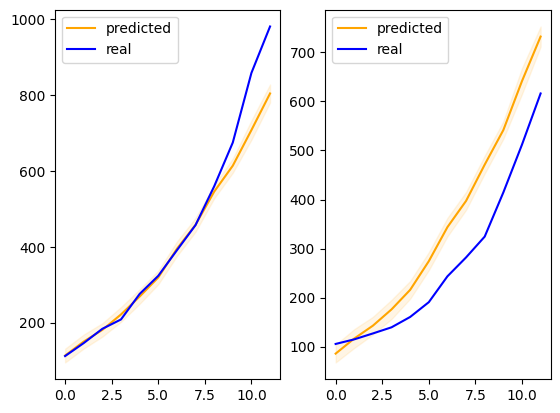

In [8]:
fig, ax = plt.subplots(1, 2)
for plant_id in range(2):
    # get subset of val_df with plant_id
    this_val_df = val_df.filter(pl.col("plant_id") == plant_id)
    input_data = np.vstack(
        list(
            zip(
                this_val_df["clean_area"].to_list(),
                this_val_df["red_coef"].to_list(),
                this_val_df["white_coef"].to_list(),
                this_val_df["blue_coef"].to_list(),
                this_val_df["red_coef_trace_0.5"].to_list(),
                this_val_df["white_coef_trace_0.5"].to_list(),
                this_val_df["blue_coef_trace_0.5"].to_list(),
            )
        )
    )
    output_data = np.vstack(this_val_df["next_clean_area"].to_list())
    MEAN = []
    STD = []
    current_area = input_data[0][0]
    for i in range(len(output_data)):
        input = np.hstack([[current_area], input_data[i][1:]])
        predictive_mean, predictive_std = GP_model.predict_mean_std(np.vstack([input]))
        MEAN.append(current_area + predictive_mean[0])
        STD.append(predictive_std[0])
        current_area += predictive_mean[0]

    MEAN = np.array(MEAN)
    STD = np.array(STD)

    ax[plant_id].plot(MEAN, color="orange", label="predicted")
    ax[plant_id].fill_between(
        np.arange(len(output_data)),
        MEAN - 1 * STD,
        MEAN + 1 * STD,
        alpha=0.1,
        color="orange",
    )
    ax[plant_id].plot(output_data, color="blue", label="real")

    ax[plant_id].legend()

In [12]:
actions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
test_area = np.linspace(0, 1000, 100)
tests = [
    np.vstack([[area] + actions[i] + [0.33, 0.33, 0.33] for area in test_area])
    for i in range(3)
]
Mean = []
Std = []
for i in range(3):
    predictive_mean, predictive_std = GP_model.predict_mean_std(tests[i])
    Mean.append(predictive_mean)
    Std.append(predictive_std)

/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


/tmp/ipykernel_3230/2951416745.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


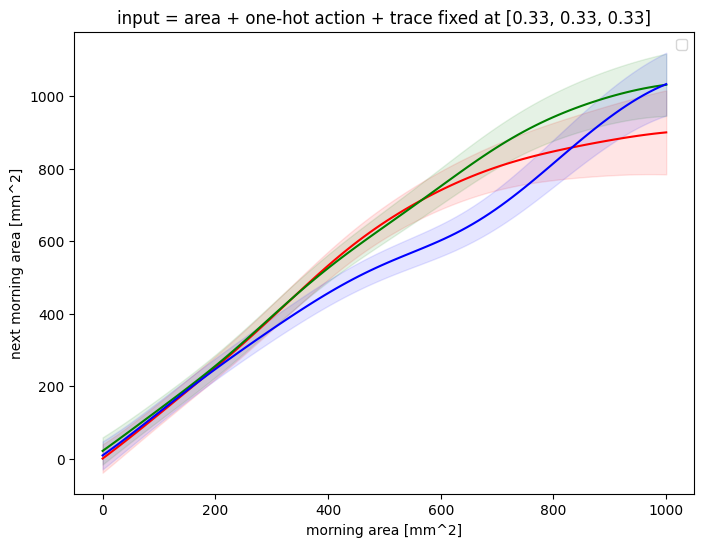

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
COLORS = ["r", "g", "b"]
for i in range(3):
    ax.plot(test_area, Mean[i], color=COLORS[i])
    ax.fill_between(
        test_area.squeeze(),
        Mean[i] - 1 * Std[i],
        Mean[i] + 1 * Std[i],
        alpha=0.1,
        color=COLORS[i],
    )
ax.set_xlabel("morning area [mm^2]")
ax.set_ylabel("next morning area [mm^2]")
ax.set_title(f"input = area + one-hot action + trace fixed at [0.33, 0.33, 0.33]")
# ax.set_title(f"input = area + one-hot action ")
ax.legend()
# ax.set_xlim([100, 1000])
# ax.set_ylim([100., 750])